# Activated Labours: data analysis and time series
The purpose of this notebook is to have an initial view of the data contained in the **Rapporti_di_lavoro_attivati**.
The objective of this study is to have an initial understanding of eventually founded trends over number of activated labours during the past time.
Next steps will be to add more deep analysis about time and some particular features that are present in the dataset. 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re
import utils
from matplotlib import rcParams
from tqdm import tqdm

a4_dims = (11.7, 8.27)
rcParams['figure.figsize'] = a4_dims

STD_SIZE = (15, 10)
MID_SIZE = (25, 20)
BIG_SIZE = (30, 30)

## Have a first view of the dataset

Import the dataset

In [13]:
activated_labours = pd.read_csv('datasets/Rapporti_di_lavoro_attivati.csv', parse_dates=['DATA'])
print(f'Shape: {activated_labours.shape}')
activated_labours.head()

Shape: (9579794, 9)


,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,2020-09-05,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,2019-12-07,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,2013-05-06,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,2010-12-03,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,2021-06-04,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA


Inspect data types

In [14]:
activated_labours.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
ITALIANO                             object
dtype: object

In [15]:
len(activated_labours)

9579794

Some general information

In [16]:
activated_labours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     object        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  object        
 4   TITOLOSTUDIO               object        
 5   CONTRATTO                  object        
 6   MODALITALAVORO             object        
 7   PROVINCIAIMPRESA           object        
 8   ITALIANO                   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 657.8+ MB


### Sort records basing on **DATA** column

Sorting the data with respect to the **DATA** column is only required for making some time series analysis, which will be eventually performed later on.

In [17]:
activated_labours['DATA'].head()

0   2020-09-05
1   2019-12-07
2   2013-05-06
3   2010-12-03
4   2021-06-04
Name: DATA, dtype: datetime64[ns]

Sort basing on dates

In [18]:
activated_labours = activated_labours.sort_values(by='DATA', ascending=True)
activated_labours.reset_index(drop=True, inplace=True)
min_ok = activated_labours.DATA.min() == activated_labours.DATA[0]
max_ok = activated_labours.DATA.max() == activated_labours.DATA[len(activated_labours) - 1]
print('Sorted' if min_ok and max_ok else 'Not sorted')

Sorted


## Inspection of null values

In [19]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6
SETTOREECONOMICODETTAGLIO,2888,0.0
TITOLOSTUDIO,580,0.0


Only three columns contains null values... Let's inspect more deeply how could i remove them.

### TITOLO DI STUDIO

In [20]:
activated_labours.loc[:, ['TITOLOSTUDIO']].value_counts()

TITOLOSTUDIO                                                                                                           
NESSUN TITOLO DI STUDIO                                                                                                    2721891
LICENZA MEDIA                                                                                                              2523342
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA                                          2430781
LAUREA - Vecchio o nuovo ordinamento                                                                                        988171
TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()     645228
LICENZA ELEMENTARE                                                                                                           82570
DIPLOMA UNIVERSITARIO                                                                         

I'll fill in all the null values in the **TITOLO DI STUDIO** column with the **NESSUN TITOLO DI STUDIO** value

In [21]:
activated_labours.TITOLOSTUDIO.fillna('NESSUN TITOLO DI STUDIO', inplace=True)

/home/ale/anaconda3/envs/datasciencefb/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


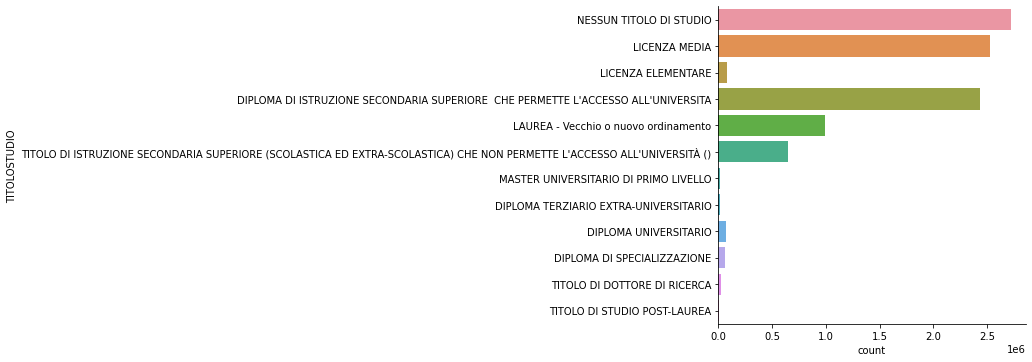

In [22]:
sns.catplot(data=activated_labours, y='TITOLOSTUDIO', kind='count')

In [23]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6
SETTOREECONOMICODETTAGLIO,2888,0.0


### SETTORE ECONOMICO DETTAGLIO

In [24]:
counts = activated_labours.loc[:, ['SETTOREECONOMICODETTAGLIO']].value_counts()
counts

SETTOREECONOMICODETTAGLIO                                                                                                                                                      
Alberghi                                                                                                                                                                           467057
Ristorazione con somministrazione                                                                                                                                                  445191
Attività di produzione cinematografica, di video e di programmi televisivi                                                                                                         379116
Attività di famiglie e convivenze come datori di lavoro per personale domestico                                                                                                    348181
Altri servizi di supporto alle imprese nca                                      

In [25]:
counts.shape[0]

1224

<BarContainer object of 18 artists>

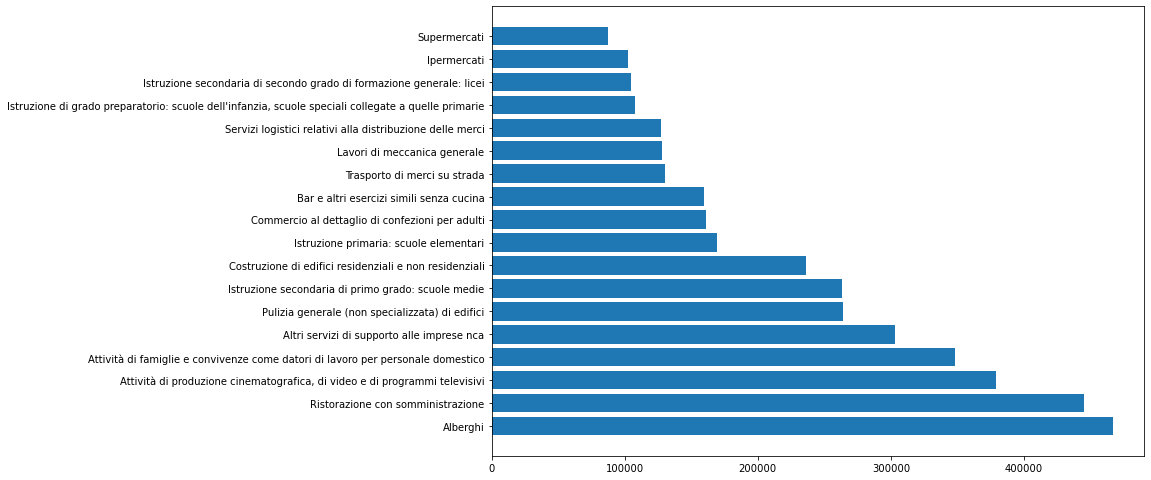

In [26]:
LIMIT = 80000
counts = counts[counts.values > LIMIT]
plt.barh(y=[i[0] for i in counts.index], width=counts.values)

Column **settore economico dettaglio** contains too general information and a lot of values which have a too small amount of count. In order to make an understandable plot i would have to avoid considering too many values, so for now i'll drop it.

In [27]:
activated_labours.drop(labels=['SETTOREECONOMICODETTAGLIO'], axis=1, inplace=True)

In [28]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6


### MODALITA LAVORO

In [29]:
activated_labours.loc[:, ['MODALITALAVORO']].value_counts()

MODALITALAVORO            
TEMPO PIENO                   5337940
TEMPO PARZIALE ORIZZONTALE    2026056
NON DEFINITO                  1087460
TEMPO PARZIALE MISTO           445419
TEMPO PARZIALE VERTICALE       242140
dtype: int64

Fill null values into **modalità lavoro** with value **NON DEFINITO**

In [30]:
activated_labours['MODALITALAVORO'] = activated_labours['MODALITALAVORO'].fillna('NON DEFINITO')
activated_labours['MODALITALAVORO'].isnull().sum()

0

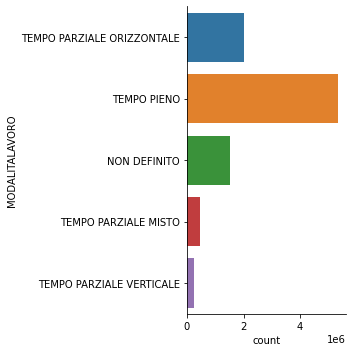

In [31]:
sns.catplot(data=activated_labours, y='MODALITALAVORO', kind='count')

In [32]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Now the dataframe contains **0** null values.

# Duplicated records

In [33]:
activated_labours.duplicated().sum()

2536002

the presence of duplicated lines is not meaningful because there could be different people with same characteristics having activated a labour in the same day

Rename column **ITALIANO** into **NAZIONALITA**

In [34]:
activated_labours.rename({'ITALIANO': 'NAZIONALITA'}, axis=1, inplace=True)

### Plot of categorical data distributions

['GENERE', 'TITOLOSTUDIO', 'CONTRATTO', 'MODALITALAVORO', 'PROVINCIAIMPRESA', 'NAZIONALITA']


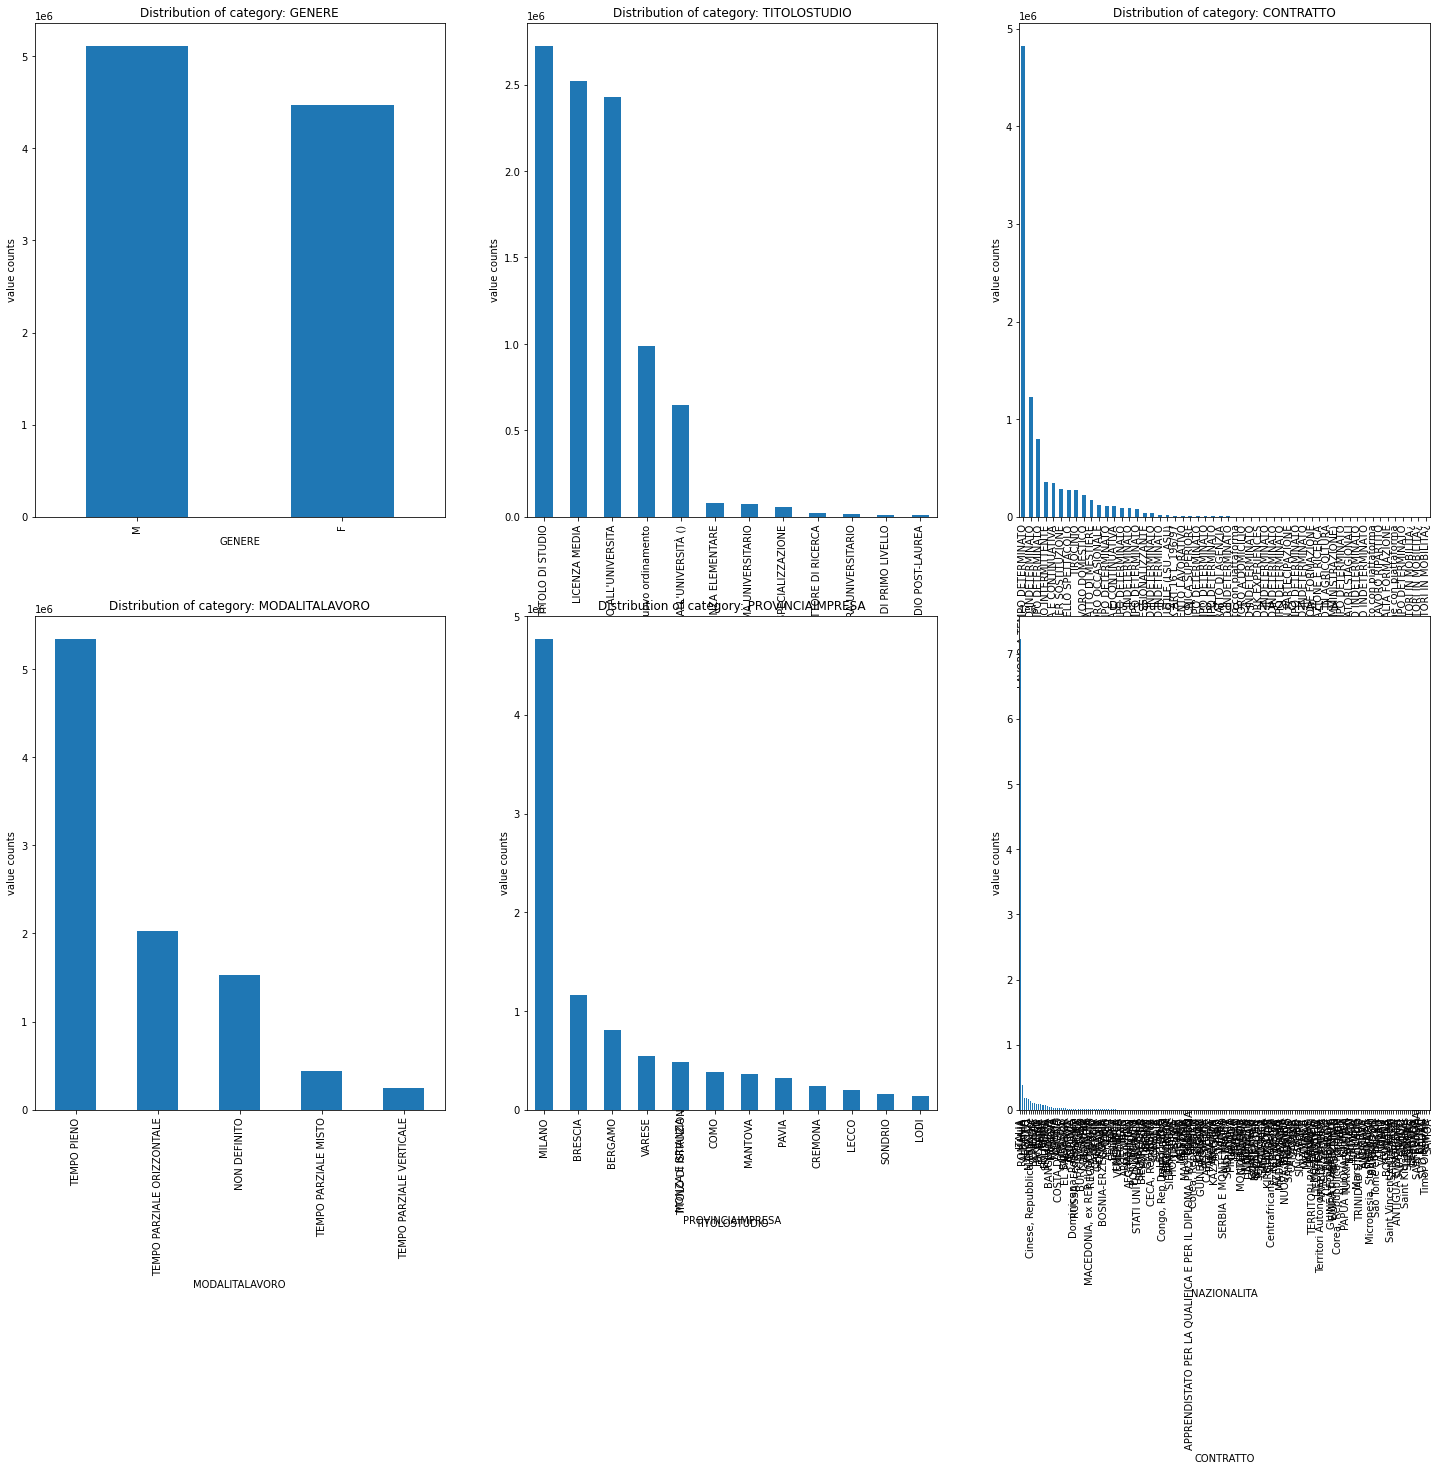

In [35]:
categorical_features = [col for col in activated_labours if activated_labours[col].dtype == 'object']
print(categorical_features)

fig = plt.figure(figsize=MID_SIZE)
for i, category in enumerate(categorical_features):
    ax = fig.add_subplot(2, 3, i+1)
    freqs = activated_labours[category].value_counts()
    freqs.plot.bar(x=freqs.index, y=freqs.values)
    ax.set_title('Distribution of category: %s' % category)
    ax.set_xlabel(category)
    ax.set_ylabel('value counts')
plt.show()

### Plot of numerical data distribution

In [36]:
activated_labours.ETA[activated_labours.ETA > 100]

76879      101
9579793    221
Name: ETA, dtype: int64

I remove the person that has 221 years

In [37]:
activated_labours = activated_labours[activated_labours.ETA != 221]
activated_labours.ETA.max()

101

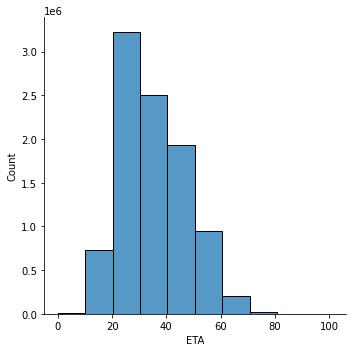

In [38]:
sns.displot(activated_labours.ETA, bins=10)

### Descriptive statistics

The following function prints some useful measures of variability in order to have a clearer understanding of the **ETA** column, which is the only column that contains numerical values.

In [39]:
utils.variability_measures(activated_labours, column='ETA', limit=0.1)

Mean on column ETA: 35.301722072700315
Median on column ETA: 34.0
Mode on column ETA: 0    25
Name: ETA, dtype: int64
Variance on column ETA: 138.81999306057614
Standard deviation on column ETA: 11.782189654753319
Trimmed mean on column ETA with limit 0.1: 34.23565773871471
Mean absolute deviation on column ETA: 9.84983217089415
Median absolute deviation on column ETA: 9.76870418807588


In [40]:
# activated_labours.to_csv('./activated_labours_cleaned.csv')

### Add some data representing the daily retribution of labours with respect to **GENERE**, **TITOLODISTUDIO** and **ANNO**

In [41]:
retributions = pd.read_csv('datasets/retribuzioni2.csv')
retributions.head()

,ITTER107,Territorio,TIPO_DATO7,Tipo dato,SEXISTAT1,Sesso,TITOLO_STUDIO,Titolo di studio,PROFILO_PROF,Qualifica contrattuale,ATECO_2007,Ateco 2007,CLLVT,Classe di dipendenti,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,ITC,Nord-ovest,HOUWAG_ENTEMP_MED_MI,Retribuzione lorda oraria per ora retribuita ...,1,maschi,11,laurea e post-laurea,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2014,2014,13.10,NaN,NaN
1,ITC,Nord-ovest,HOUWAG_ENTEMP_MED_MI,Retribuzione lorda oraria per ora retribuita ...,1,maschi,11,laurea e post-laurea,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2015,2015,12.44,NaN,NaN
2,ITC,Nord-ovest,HOUWAG_ENTEMP_MED_MI,Retribuzione lorda oraria per ora retribuita ...,1,maschi,11,laurea e post-laurea,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2016,2016,NaN,c,dato oscurato per la tutela del segreto statis...
3,ITC,Nord-ovest,HOUWAG_ENTEMP_MED_MI,Retribuzione lorda oraria per ora retribuita ...,1,maschi,11,laurea e post-laurea,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2017,2017,NaN,c,dato oscurato per la tutela del segreto statis...
4,ITC,Nord-ovest,HOUWAG_ENTEMP_MED_MI,Retribuzione lorda oraria per ora retribuita ...,1,maschi,11,laurea e post-laurea,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2018,2018,NaN,c,dato oscurato per la tutela del segreto statis...


Firstly clean the dataset

In [42]:
retributions.shape

(9682, 19)

In [43]:
retributions.columns

Index(['ITTER107', 'Territorio', 'TIPO_DATO7', 'Tipo dato', 'SEXISTAT1',
       'Sesso', 'TITOLO_STUDIO', 'Titolo di studio', 'PROFILO_PROF',
       'Qualifica contrattuale', 'ATECO_2007', 'Ateco 2007', 'CLLVT',
       'Classe di dipendenti', 'TIME', 'Seleziona periodo', 'Value',
       'Flag Codes', 'Flags'],
      dtype='object')

Dropping unuseful or duplicated columns

In [44]:
retributions2 = retributions.drop(['ITTER107', 'TIPO_DATO7', 'Tipo dato', 'SEXISTAT1', 'TITOLO_STUDIO', 'PROFILO_PROF', 'ATECO_2007', 'CLLVT', 'Classe di dipendenti', 'TIME', 'Flag Codes', 'Flags'], axis=1)
retributions2.columns

Index(['Territorio', 'Sesso', 'Titolo di studio', 'Qualifica contrattuale',
       'Ateco 2007', 'Seleziona periodo', 'Value'],
      dtype='object')

Rename column **Seleziona periodo** in **anno**

In [45]:
retributions2.rename({'Seleziona periodo': 'anno'}, axis=1, inplace=True)
retributions2.anno.unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [46]:
retributions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9682 entries, 0 to 9681
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Territorio              9682 non-null   object 
 1   Sesso                   9682 non-null   object 
 2   Titolo di studio        9682 non-null   object 
 3   Qualifica contrattuale  9682 non-null   object 
 4   Ateco 2007              9682 non-null   object 
 5   anno                    9682 non-null   int64  
 6   Value                   8758 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 529.6+ KB


### Missing values inspection

In [47]:
utils.missing_values_table(retributions2)

Your selected dataframe has 7 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Value,924,9.5


There are some missing values only on the **Values** column. Since there are only a few i'll drop all the rows containig missing values for that column.

In [48]:
retributions3 = retributions2.dropna()

In [49]:
utils.missing_values_table(retributions3)

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


All missing values have been removed

Convert all column names to upper case in order to simplify the join operation

In [50]:
retributions3.columns = retributions3.columns.str.upper()
retributions3.head()

,TERRITORIO,SESSO,TITOLO DI STUDIO,QUALIFICA CONTRATTUALE,ATECO 2007,ANNO,VALUE
0,Nord-ovest,maschi,laurea e post-laurea,operaio,estrazione di minerali da cave e miniere,2014,13.10
1,Nord-ovest,maschi,laurea e post-laurea,operaio,estrazione di minerali da cave e miniere,2015,12.44
5,Nord-ovest,maschi,laurea e post-laurea,operaio,estrazione di minerali da cave e miniere,2019,13.74
9,Nord-ovest,maschi,laurea e post-laurea,apprendista,estrazione di minerali da cave e miniere,2017,19.60
10,Nord-ovest,maschi,laurea e post-laurea,apprendista,estrazione di minerali da cave e miniere,2018,18.24


In [51]:
retributions3.shape[0]

8758

Since the dataset **rapporti_di_lavoro_attivati** contains only data that makes reference to Lombardy i'll keep only the records which make reference to **NORD-OVEST** as territory.

In [52]:
retributions4 = retributions3[retributions3['TERRITORIO'] == 'Nord-ovest']
retributions4.drop('TERRITORIO', axis=1, inplace=True)
retributions4.shape[0]

<ipython-input-52-3064745fc066>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retributions4.drop('TERRITORIO', axis=1, inplace=True)


1835

Refactoring of some values in order to let them be coherent with tha values of the starting dataframe.

In [53]:
retributions4['SESSO'] = retributions4['SESSO'].replace({'maschi': 'M', 'femmine': 'F'})
retributions4['SESSO'].unique() 

<ipython-input-53-38a676a592ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retributions4['SESSO'] = retributions4['SESSO'].replace({'maschi': 'M', 'femmine': 'F'})


array(['M', 'F'], dtype=object)

In [54]:
retributions4['TITOLO DI STUDIO'] = retributions4['TITOLO DI STUDIO'].str.upper()
retributions4['TITOLO DI STUDIO'].unique()

<ipython-input-54-d05f8b689524>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retributions4['TITOLO DI STUDIO'] = retributions4['TITOLO DI STUDIO'].str.upper()


array(['LAUREA E POST-LAUREA', 'DIPLOMA',
       'NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA'],
      dtype=object)

In [55]:
retributions4['QUALIFICA CONTRATTUALE'] = retributions4['QUALIFICA CONTRATTUALE'].str.upper()
retributions4['QUALIFICA CONTRATTUALE'].unique()

<ipython-input-55-90d111c7d858>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retributions4['QUALIFICA CONTRATTUALE'] = retributions4['QUALIFICA CONTRATTUALE'].str.upper()


array(['OPERAIO', 'APPRENDISTA', 'DIRIGENTE; IMPIEGATO'], dtype=object)

In [56]:
retributions4['ATECO 2007'] = retributions4['ATECO 2007'].str.upper()
retributions4['ATECO 2007'].unique()

<ipython-input-56-cbdc431e99de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retributions4['ATECO 2007'] = retributions4['ATECO 2007'].str.upper()


array(['ESTRAZIONE DI MINERALI DA CAVE E MINIERE',
       'ATTIVITÀ MANIFATTURIERE',
       'FORNITURA DI ENERGIA ELETTRICA, GAS, VAPORE E ARIA CONDIZIONATA',
       'FORNITURA DI ACQUA RETI FOGNARIE, ATTIVITÀ DI GESTIONE DEI RIFIUTI E RISANAMENTO',
       'COSTRUZIONI',
       "COMMERCIO ALL'INGROSSO E AL DETTAGLIO, RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI",
       'TRASPORTO E MAGAZZINAGGIO',
       'ATTIVITÀ DEI SERVIZI DI ALLOGGIO E DI RISTORAZIONE',
       'SERVIZI DI INFORMAZIONE E COMUNICAZIONE',
       'ATTIVITÀ FINANZIARIE E ASSICURATIVE', 'ATTIVITÀ IMMOBILIARI',
       'ATTIVITÀ PROFESSIONALI, SCIENTIFICHE E TECNICHE',
       'NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPORTO ALLE IMPRESE',
       'ISTRUZIONE', 'SANITÀ E ASSISTENZA SOCIALE',
       'ATTIVITÀ ARTISTICHE, SPORTIVE, DI INTRATTENIMENTO E DIVERTIMENTO',
       'ALTRE ATTIVITÀ DI SERVIZI', 'SERVIZI  (G-S, ESCLUSO O)'],
      dtype=object)

### Renaming the columns on which i want to make the join

In [57]:
retributions4.columns

Index(['SESSO', 'TITOLO DI STUDIO', 'QUALIFICA CONTRATTUALE', 'ATECO 2007',
       'ANNO', 'VALUE'],
      dtype='object')

In [58]:
retributions4 = retributions4.rename({'SESSO': 'GENERE',
                      'TITOLO DI STUDIO': 'TITOLOSTUDIO'}, axis=1)
retributions4.columns

Index(['GENERE', 'TITOLOSTUDIO', 'QUALIFICA CONTRATTUALE', 'ATECO 2007',
       'ANNO', 'VALUE'],
      dtype='object')

### Adaptations on rapporti_di_lavoro_attivati.csv dataset
* In order to let the data be correctly joined i need to transform also some data in the **rapporti_di_lavoro_attivati** dataset.
By this way i want to obtain less null values as possible.

Importing...

In [59]:
activated_cleaned = pd.read_csv('./datasets/activated_labours_cleaned.csv', parse_dates=['DATA'], index_col=0)
# activated_cleaned.drop('Unnamed: 0', axis=1, inplace=True)
# activated_cleaned.set_index('DATA', inplace=True)
activated_cleaned.head()

,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
0,1973-02-01,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1,1974-11-06,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
2,1976-01-10,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
3,1978-01-05,M,25,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA
4,1978-10-07,M,26,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA


Create column **ANNO** for joining purposes

In [60]:
activated_cleaned['ANNO'] = pd.DatetimeIndex(activated_cleaned.DATA).year
activated_cleaned.head()

,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,ANNO
0,1973-02-01,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA,1973
1,1974-11-06,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA,1974
2,1976-01-10,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,1976
3,1978-01-05,M,25,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,1978
4,1978-10-07,M,26,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,1978


In [61]:
activated_cleaned['TITOLOSTUDIO'].unique()

array(['NESSUN TITOLO DI STUDIO', 'LICENZA MEDIA', 'LICENZA ELEMENTARE',
       "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LAUREA - Vecchio o nuovo ordinamento',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI DOTTORE DI RICERCA',
       'TITOLO DI STUDIO POST-LAUREA'], dtype=object)

In [62]:
retributions4['TITOLOSTUDIO'].unique()

array(['LAUREA E POST-LAUREA', 'DIPLOMA',
       'NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA'],
      dtype=object)

I reduce the values of **TITOLOSTUDIO** in order to increase the compatibility between the two datasets at joining.

In [63]:
study_titles_map = {'NESSUN TITOLO DI STUDIO': 'NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA',
                    'LICENZA MEDIA': 'NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA',
                    'LICENZA ELEMENTARE': 'NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA',
                    'LAUREA': 'LAUREA E POST-LAUREA',
                    'LAUREA - Vecchio o nuovo ordinamento': 'LAUREA E POST-LAUREA',
                    'TITOLO DI STUDIO POST-LAUREA': 'LAUREA E POST-LAUREA',
                    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO',
                    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO',
                    'DIPLOMA UNIVERSITARIO' : 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO'}
activated_cleaned['TITOLOSTUDIO'] = activated_cleaned['TITOLOSTUDIO'].replace(study_titles_map)
activated_cleaned.head()

,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,ANNO
0,1973-02-01,F,20,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA,1973
1,1974-11-06,F,21,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA,1974
2,1976-01-10,F,21,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,1976
3,1978-01-05,M,25,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,1978
4,1978-10-07,M,26,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,1978


Modify also a value in the **retribuzioni** dataset.

In [64]:
retributions4['TITOLOSTUDIO'] = retributions4['TITOLOSTUDIO'].replace({'DIPLOMA': 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO'})
retributions4.head()

,GENERE,TITOLOSTUDIO,QUALIFICA CONTRATTUALE,ATECO 2007,ANNO,VALUE
0,M,LAUREA E POST-LAUREA,OPERAIO,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,2014,13.10
1,M,LAUREA E POST-LAUREA,OPERAIO,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,2015,12.44
5,M,LAUREA E POST-LAUREA,OPERAIO,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,2019,13.74
9,M,LAUREA E POST-LAUREA,APPRENDISTA,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,2017,19.60
10,M,LAUREA E POST-LAUREA,APPRENDISTA,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,2018,18.24


In [65]:
activated_cleaned.groupby('ANNO').count()

,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
ANNO,,,,,,,,
1973,1,1,1,1,1,1,1,1
1974,1,1,1,1,1,1,1,1
1976,1,1,1,1,1,1,1,1
1978,2,2,2,2,2,2,2,2
1979,1,1,1,1,1,1,1,1
1980,1,1,1,1,1,1,1,1
1981,1,1,1,1,1,1,1,1
1982,1,1,1,1,1,1,1,1
1988,1,1,1,1,1,1,1,1


Since the **retribuzioni** dataset contains only records which make reference to the period between 2014 and 2019, i'll keep only the values that are part of this time interval.

In [66]:
activated_cleaned = activated_cleaned[activated_cleaned['ANNO'].isin([2014, 2015, 2016, 2017, 2018, 2019])]
activated_cleaned.reset_index(inplace=True)
activated_cleaned.ANNO.unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

### Make the join

Find out it the columns in common between the two datasets are the ones which we expected.

In [67]:
intersection = []
for col in retributions4.columns:
    if col in activated_cleaned.columns:
        intersection.append(col)
intersection

['GENERE', 'TITOLOSTUDIO', 'ANNO']

Checking...

In [68]:
contained1 = True
for value in retributions4['GENERE'].unique():
    if value not in activated_cleaned['GENERE'].unique():
        contained1 = False
        print(value)
        
contained2 = True
for value in retributions4['TITOLOSTUDIO'].unique():
    if value not in activated_cleaned['TITOLOSTUDIO'].unique():
        contained2 = False
        print(value)
        
contained3 = True
for value in retributions4['ANNO'].unique():
    if value not in activated_cleaned['ANNO'].unique():
        contained3 = False
        print(value)
        
print(contained1, contained2, contained3)

True True True


### Building a look up table for simply adding retribution values to the main dataframe

I found out that my computer has not enough memory to perform the join, so i'll perform it in a different way:
* I create a look up table with a multi-index containing the columns shared between the datasets.
* I apply a function on axis=0 by extracting the values of **GENERE**, **ANNO**, **TITOLOSTUDIO** and i use these values to indicize the value of **VALUE** which should be added to the considered record.

In [69]:
retr = retributions4[['GENERE', 'ANNO', 'TITOLOSTUDIO', 'VALUE']].groupby(['GENERE', 'ANNO', 'TITOLOSTUDIO']).mean()
retr1 = retr.T
retr1

GENERE                                                                                              F  \
ANNO                                                                                             2014   
TITOLOSTUDIO DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO   
VALUE                                                 10.788077                                         

GENERE                             \
ANNO                                
TITOLOSTUDIO LAUREA E POST-LAUREA   
VALUE                    11.90449   

GENERE                                                                      \
ANNO                                                                         
TITOLOSTUDIO NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA   
VALUE                                                     10.21              

GENERE                                                                                                 \
ANNO                                                                                             2015   
TITOLOSTUDIO DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO   
VALUE                                                 10.894038                                         

GENERE                             \
ANNO                                
TITOLOSTUDIO LAUREA E POST-LAUREA   
VALUE                   12.116122   

GENERE                                                                      \
ANNO                                                                         
TITOLOSTUDIO NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA   
VALUE                                                 10.380204              

GENERE                                                                                                 \
ANNO                                                                                             2016   
TITOLOSTUDIO DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO   
VALUE                                                 10.895098                                         

GENERE                             \
ANNO                                
TITOLOSTUDIO LAUREA E POST-LAUREA   
VALUE                   12.088367   

GENERE                                                                      \
ANNO                                                                         
TITOLOSTUDIO NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA   
VALUE                                                 10.297143              

GENERE                                                                                                 \
ANNO                                                                                             2017   
TITOLOSTUDIO DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO   
VALUE                                                 10.907843                                         

GENERE        ...  \
ANNO          ...   
TITOLOSTUDIO  ...   
VALUE         ...   

GENERE                                                                   M  \
ANNO                                                                  2016   
TITOLOSTUDIO NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA   
VALUE                                                 11.925294              

GENERE                                                                                                 \
ANNO                                                                                             2017   
TITOLOSTUDIO DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE, TERZIARIO EXTRA-UNIVERSITARIO, UNIVERSITARIO   
VALUE                                                 12.801321                                         

GENERE                             \
ANNO                                
TITOLOSTUDIO LAUREA E POST-LAUREA   


An example:

In [70]:
retr1['F', 2015, 'NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELEMENTARE E MEDIA'][0]

10.380204081632654

Getting retributions effectively

In [71]:
def get_retribution(x):
    value = 0
    try:
        value = round(retr1[x['GENERE'], x['ANNO'], x['TITOLOSTUDIO']][0], 3)
    except KeyError:
        value = np.nan
    return value

Application of the function to preform the join takes between 5 and 100 minutes, so i load the dataset with the ready to use data that i have computed before.

In [73]:
# retributions = []
# for x in tqdm(activated_cleaned.iterrows(), total=activated_cleaned.shape[0]):
#     print(x[1]['ANNO'])
#     retributions.append(get_retribution(x[1]))

# activated_cleaned['RETRIBUZIONE'] = retributions

activated_cleaned = pd.read_csv('datasets/activated_with_retributions2.csv', index_col=0, parse_dates=['DATA'])
activated_cleaned.drop('index', inplace=True, axis=1) 
activated_cleaned.head()

,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,ANNO,RETRIBUZIONE
0,2014-01-01,F,49,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,VARESE,MAROCCO,2014,10.210
1,2014-01-01,F,52,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,MANTOVA,ALBANIA,2014,10.210
2,2014-01-01,F,43,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,2014,10.210
3,2014-01-01,M,29,"NESSUN TITOLO DI STUDIO, LICENZA DI SCUOLA ELE...",LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,BANGLADESH,2014,12.070
4,2014-01-01,F,29,LAUREA E POST-LAUREA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ITALIA,2014,11.904


In [74]:
activated_cleaned.RETRIBUZIONE.info()

<class 'pandas.core.series.Series'>
Int64Index: 4829316 entries, 0 to 4829315
Series name: RETRIBUZIONE
Non-Null Count    Dtype  
--------------    -----  
4479832 non-null  float64
dtypes: float64(1)
memory usage: 73.7 MB


In [75]:
utils.missing_values_table(activated_cleaned)

Your selected dataframe has 10 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
RETRIBUZIONE,349484,7.2


Fill the missing values produced with the mean

In [76]:
activated_cleaned.RETRIBUZIONE.fillna(activated_cleaned.RETRIBUZIONE.mean(), inplace=True)

In [77]:
utils.missing_values_table(activated_cleaned)

Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Let's have a look at the new data

Distribution of retributions with respect to **TITOLO DI STUDIO**. Each subset is independently normalized.

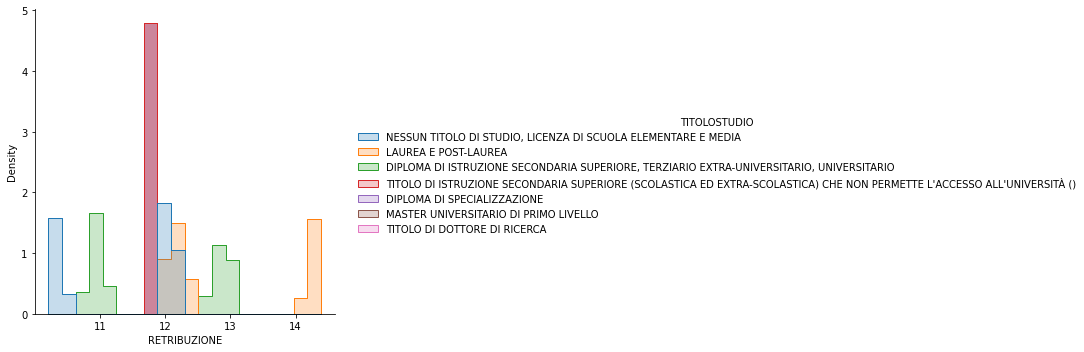

In [96]:
sns.displot(data=activated_cleaned, x='RETRIBUZIONE', hue='TITOLOSTUDIO', element='step', bins=20, stat='density', common_norm=False)

# Transformations notebook

In this notebook i'm performing some transformations on the **Rapporti_di_lavoro_attivati.csv** dataset in order to convert all the categorical features into numerical features, which are more suitable for the predicting stage.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import missing_values_table
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score


In [4]:
activated_labours = pd.read_csv('./activated_labours_cleaned.csv')
activated_labours.head()

,Unnamed: 0,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
0,0,1973-02-01,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1,1,1974-11-06,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
2,2,1976-01-10,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
3,3,1978-01-05,M,25,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA
4,4,1978-10-07,M,26,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA


## Transformations

In [5]:
activated_transformed = pd.DataFrame()

Converting **GENERE** column to dummies

In [6]:
df_col = activated_labours['GENERE'].values.reshape(-1,1)
df_col

array([['F'],
       ['F'],
       ['F'],
       ...,
       ['M'],
       ['F'],
       ['M']], dtype=object)

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc_gen = OneHotEncoder()
X = enc_gen.fit_transform(df_col).toarray()
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [8]:
dfOneHot = pd.DataFrame(X, columns = ['GENERE_F', 'GENERE_M'])
activated_transformed = pd.concat([activated_transformed, dfOneHot], axis=1)
activated_transformed.head()

,GENERE_F,GENERE_M
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


Transforming **TITOLO STUDIO** with manually defined transformation(in order to maintain the ordinal information of data).

[ISTAT document](https://www.istat.it/it/files/2011/01/Classificazione-titoli-studio-28_ott_2005-nota_metodologica.pdf)

In [9]:
activated_labours.TITOLOSTUDIO.unique()

array(['NESSUN TITOLO DI STUDIO', 'LICENZA MEDIA', 'LICENZA ELEMENTARE',
       "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LAUREA - Vecchio o nuovo ordinamento',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI DOTTORE DI RICERCA',
       'TITOLO DI STUDIO POST-LAUREA'], dtype=object)

In [10]:
studylevel_mapper = {'NESSUN TITOLO DI STUDIO': 0,
          'LICENZA ELEMENTARE': 1,
          'LICENZA MEDIA': 2,
          'TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L\'ACCESSO ALL\'UNIVERSITÀ ()': 3,
          'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 4,
          'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 5,
          'DIPLOMA UNIVERSITARIO': 6,
          'LAUREA - Vecchio o nuovo ordinamento': 7,
          'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 8,
          'DIPLOMA DI SPECIALIZZAZIONE': 9,
          'TITOLO DI DOTTORE DI RICERCA': 10,
          'TITOLO DI STUDIO POST-LAUREA': 11,}
activated_transformed['TITOLOSTUDIO'] = activated_labours['TITOLOSTUDIO'].replace(studylevel_mapper)
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO
0,1.0,0.0,0
1,1.0,0.0,0
2,1.0,0.0,0
3,0.0,1.0,0
4,0.0,1.0,0


In [11]:
activated_transformed.TITOLOSTUDIO.unique()

array([ 0,  2,  1,  4,  7,  3,  8,  5,  6,  9, 10, 11])

Transforming **MODALITÀ LAVORO** using LabelEncoder

In [12]:
activated_labours.MODALITALAVORO.unique()

array(['TEMPO PARZIALE ORIZZONTALE', 'TEMPO PIENO', 'NON DEFINITO',
       'TEMPO PARZIALE MISTO', 'TEMPO PARZIALE VERTICALE'], dtype=object)

In [13]:
le_workmode = LabelEncoder()
transformed_col = le_workmode.fit_transform(activated_labours.MODALITALAVORO)
transformed_col

array([2, 2, 2, ..., 0, 2, 4])

In [14]:
activated_transformed['MODALITALAVORO'] = transformed_col
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO
0,1.0,0.0,0,2
1,1.0,0.0,0,2
2,1.0,0.0,0,2
3,0.0,1.0,0,4
4,0.0,1.0,0,4


In [15]:
activated_transformed.MODALITALAVORO.unique()

array([2, 4, 0, 1, 3])

Transforming **PROVINCIA IMPRESA** and **NAZIONALITÀ**

Potremmo provare a predire MODALITÀ LAVORO partendo da genere, titolo di studio, provincia impresa ed età

Potremmo provare ad applicate principal component analysis prima di fare le predizioni e scaling dei dati

Potremmo provare a predire la permanenza media di una persona con un certo tipo di lavoro o contratto, confrontare il numero di lavori attivati con quelli cessati in un determinato periodo...

In [16]:
activated_labours.PROVINCIAIMPRESA.unique()

array(['MILANO', 'BERGAMO', 'BRESCIA', 'COMO', 'LODI', 'MONZA E BRIANZA',
       'LECCO', 'MANTOVA', 'VARESE', 'CREMONA', 'PAVIA', 'SONDRIO'],
      dtype=object)

In [17]:
le_prov = LabelEncoder()
transformed_prov = le_prov.fit_transform(activated_labours.PROVINCIAIMPRESA)
activated_transformed['PROVINCIAIMPRESA'] = transformed_prov
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA
0,1.0,0.0,0,2,7
1,1.0,0.0,0,2,7
2,1.0,0.0,0,2,0
3,0.0,1.0,0,4,7
4,0.0,1.0,0,4,7


In [18]:
activated_labours.NAZIONALITA.unique()

array(['ITALIA', 'FILIPPINE', 'EL SALVADOR', 'ROMANIA', "PERU'",
       'UCRAINA', 'SRI LANKA', 'Moldova', 'SLOVACCHIA', 'MAROCCO',
       'ECUADOR', 'GHANA', 'ALBANIA', 'BOLIVIA', 'RUSSA, Federazione',
       'Dominicana, Repubblica', 'NEPAL', 'NIGERIA', 'ERITREA',
       'BULGARIA', 'POLONIA', 'INDIA', 'SENEGAL', 'MAURITANIA', 'CROAZIA',
       'ETIOPIA', 'BANGLADESH', 'BRASILE', 'ARGENTINA', 'PAKISTAN',
       'MALI', "COSTA D'AVORIO", 'KOSOVO', 'BIELORUSSIA',
       'SERBIA E MONTENEGRO', 'CUBA', 'DOMINICA', 'VENEZUELA',
       'CAPO VERDE', 'EGITTO', 'Cinese, Repubblica Popolare', 'TUNISIA',
       'Mauritius', 'PORTOGALLO', 'LIBERIA', 'SEYCHELLES', 'PAESI BASSI',
       'COLOMBIA', 'CILE', 'IRAN', 'SERBIA', 'APOLIDE', 'GERMANIA',
       'THAILANDIA', 'TURCHIA', 'MACEDONIA, ex REP. JUGOSLAVIA', 'RUANDA',
       'CAMBOGIA', 'SOMALIA', 'INDONESIA', 'MESSICO', 'ALGERIA',
       'ESTONIA', 'BOSNIA-ERZEGOVINA', 'OMAN', 'GAMBIA', 'SUD AFRICA',
       'LETTONIA', 'GEORGIA', 'BURKINA FASO

In [19]:
le_nationality = LabelEncoder()
transformed_nationality = le_nationality.fit_transform(activated_labours.NAZIONALITA)
activated_transformed['NATIONALITY'] = transformed_nationality
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NATIONALITY
0,1.0,0.0,0,2,7,89
1,1.0,0.0,0,2,7,89
2,1.0,0.0,0,2,0,89
3,0.0,1.0,0,4,7,89
4,0.0,1.0,0,4,7,89


Every feature has been converted into numerical values.

In [20]:
#activated_transformed.to_csv('./activated_labours_transformed_reg.csv')

# Machine learning

Given a set of activated labours features we want to try to predict the study title of people.

In [21]:
# the features
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NATIONALITY
0,1.0,0.0,0,2,7,89
1,1.0,0.0,0,2,7,89
2,1.0,0.0,0,2,0,89
3,0.0,1.0,0,4,7,89
4,0.0,1.0,0,4,7,89


### Linear regression

We must check the linearity of the data to understand if we can apply the multiple linear regression.

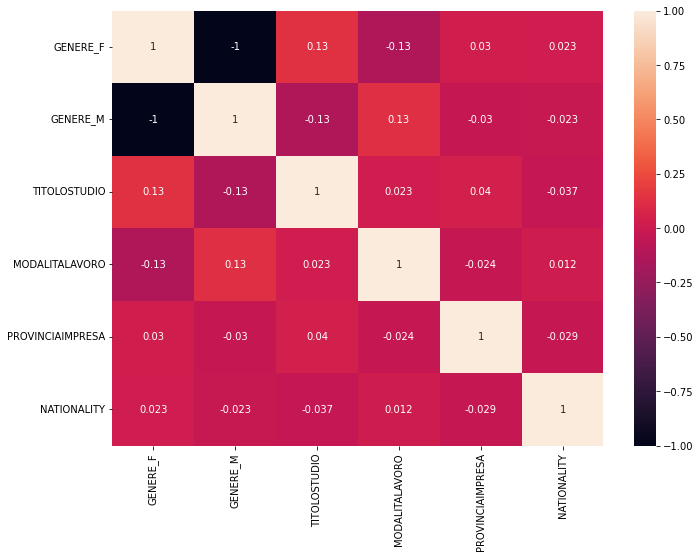

In [23]:
corrMatrix = activated_transformed.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

The correlation matrix does not show significative correlations between our features. Thus, performing the linear regression is not suitable in our case.

### XGBoost

Move target column to the last position

In [32]:
xgb_activated_transformed = activated_transformed.loc[:, activated_transformed.columns != 'TITOLOSTUDIO']
xgb_activated_transformed['TITOLOSTUDIO']= activated_transformed['TITOLOSTUDIO']

In [33]:
xgb_activated_transformed.head()

,GENERE_F,GENERE_M,MODALITALAVORO,PROVINCIAIMPRESA,NATIONALITY,TITOLOSTUDIO
0,1.0,0.0,2,7,89,0
1,1.0,0.0,2,7,89,0
2,1.0,0.0,2,0,89,0
3,0.0,1.0,4,7,89,0
4,0.0,1.0,4,7,89,0


In [37]:
#Prepare the dataset for prediction
X, y = xgb_activated_transformed.iloc[:,:-1], xgb_activated_transformed.iloc[:,-1]

In [39]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [43]:
xgbc = XGBClassifier()

In [46]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [48]:
#cross_val_score(xgbc, X_train, y_train, cv=5)

KeyboardInterrupt: 

In [ ]:
#kfold = KFold(n_splits=10, shuffle=True)
#cross_val_score(xgbc, X_train, y_train, cv=kfold )

In [50]:
ypred = xgbc.predict(X_test)

In [53]:
accuracy_score(y_test, ypred)

0.4128851400264828